In [2]:
import os
import numpy as np
import random
import librosa
import librosa.display
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


In [3]:
DATA_DIR = '/Users/james/Documents/Data/genre classification/' 
AUDIO_DIR = DATA_DIR + 'Audio' 
#TRAIN_TEST_HOLD_OUT_PROP = 0.7
TEST_PROP = 0.1
TRAIN_TEST_SPLIT = 0.7


Data functions


In [4]:
def get_downloaded_track_ids(directory):
    """
    Collect the track_ids from the tracks that have downloaded in the specific directory
    :return: ist of track ids
    """    
    track_ids = []
    for _, dirnames, files in os.walk(directory):
        if dirnames == []:
            track_ids.extend(str(file[:-4]) for file in files) # 4 spots before the '.mp3'
    return track_ids


In [5]:
def get_audio_path(directory, track_id):
    """
    Return the path to the mp3 given the directory where the audio is stored
    and the track ID.
    """
    return os.path.join(directory, track_id + '.mp3')



In [6]:
# get the successfully downloaded track id's  
track_ids = get_downloaded_track_ids(AUDIO_DIR)
print(len(track_ids))


2893


Audio Processing Functions 


In [7]:
def create_spectogram(track_id):
    filename = get_audio_path(AUDIO_DIR, track_id)
    y, sr = librosa.load(filename)
    spect = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=1024)
    spect = librosa.power_to_db(spect, ref=np.max)
    return spect.T   


In [8]:
def plot_spect(track_id):
    spect = create_spectogram(track_id)
    print(spect.shape)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(spect.T, y_axis='mel', fmax=8000, x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.show()


(2584, 128)
6197c792-63b8-437b-9dda-baf4c084c9db


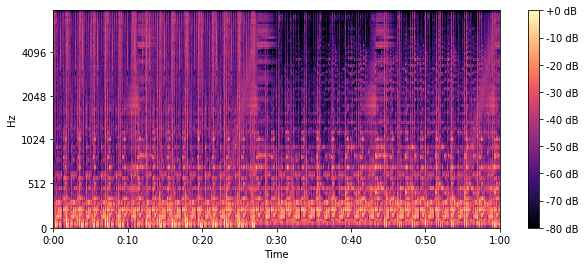

In [9]:
# example plot
plot_spect(track_ids[0])
print(track_ids[0])


Load in track genre meta data from CSV and construct training/test split


In [10]:
# load in data from csv and filter for the relevant track id's  
meta_data_df = pd.read_csv(DATA_DIR + 'Descriptive/Genre Definitions - All Genres.csv')
print(meta_data_df.shape[0])
meta_data_df = meta_data_df[meta_data_df['guid'].isin(track_ids)]
print(meta_data_df.shape[0])
keep_cols = ['guid','genre']
meta_data_df = meta_data_df[keep_cols] 


2899
2892


In [11]:
# train/valid/test
test_idx = random.sample(meta_data_df.index.tolist(),
                        int(TEST_PROP*meta_data_df.shape[0]))
# remainder is train + valid
train_valid_idx = meta_data_df.index[~np.isin(meta_data_df.index, test_idx)]

train_idx = random.sample(train_valid_idx.tolist(),
                          int(TRAIN_TEST_SPLIT*meta_data_df.shape[0]))
valid_idx = train_valid_idx[~np.isin(train_valid_idx, train_idx)]
print(len(meta_data_df.index))
print(len(train_idx))
print(len(valid_idx))
print(len(test_idx))
assert len(train_idx) + len(valid_idx) + len(test_idx) == len(meta_data_df.index), "train/test split not equal to total"


2892
2024
579
289


In [12]:
meta_data_df['split'] = np.where(np.isin(meta_data_df.index, train_idx), 
                                 'train', 
                                 np.where(np.isin(meta_data_df.index, valid_idx), 
                                          'valid',
                                          'test'
                                          )
                                 )
meta_data_df.head()


,guid,genre,split
0,f7e7a01b-0661-454b-81b0-daa747adf6c7,Afro House,train
1,12722a88-4b30-4f88-8ded-815265f2b051,Afro House,train
2,75ceb7f7-b249-4690-a2b6-be78980f1f2f,Afro House,test
3,cfdf409f-87bf-4578-b08d-555edf00bdf7,Afro House,test
4,f9fd8216-ac2e-4b73-b4b7-2da25f74c677,Afro House,train


In [13]:
meta_data_df.groupby('split')['guid'].count()


split
test      289
train    2024
valid     579
Name: guid, dtype: int64

#### Group Genres Together 


In [14]:
# proportion of genres
meta_data_df.groupby(['genre','split']).count().head(10)


guid
genre      split      
Afro House test      8
           train    76
           valid    16
Big Room   test      9
           train    69
           valid    21
Breaks     test     13
           train    67
           valid    19
Dance      test      9

In [69]:
genre_list = meta_data_df['genre'].unique()
genre_dict = {genre_list[i] : i for i in range(0, len(genre_list))}
genre_dict


{'Afro House': 0,
 'Big Room': 1,
 'Breaks': 2,
 'Dance': 3,
 'Deep House': 4,
 'Drum & Bass': 5,
 'Dubstep': 6,
 'Electro House': 7,
 'Electronica': 8,
 'Funk-Soul-Disco': 9,
 'Funk-Groove-Jackin-House': 10,
 'Future House': 11,
 'Garage-Bassline-Grime': 12,
 'Glitch': 13,
 'Hard Dance': 14,
 'Hard Techno': 15,
 'Hip-Hop': 16,
 'House': 17,
 'Indie Dance': 18,
 'Leftfield Bass': 19,
 'Leftfield House and Techno': 20,
 'Minimal Deep Tech': 21,
 'Progressive House': 22,
 'Psy-Trance': 23,
 'Reggae and Dancehall': 24,
 'Tech House': 25,
 'Techno': 26,
 'Trance': 27,
 'Trap': 28}

In [16]:
club_genres = ['Afro House', 'Big Room', 'Dance', 'Deep House', 'Electro House', 'Funk-Soul-Disco', 
               'Funk-Groove-Jackin-House', 'Future House', 'Hard Dance', 'Hard Techno', 'House',
               'Psy-Trance', 'Tech House', 'Techno', 'Trance']  
meta_data_df['genre_target'] = np.where(meta_data_df['genre'].isin(club_genres), 'club', 'bass-other') 
meta_data_df.groupby('genre_target')['guid'].count()


genre_target
bass-other    1394
club          1498
Name: guid, dtype: int64

In [70]:
genre_target_list = meta_data_df['genre_target'].unique()
genre_target_dict = {genre_target_list[i] : i  for i in range(0,len(genre_target_list))}


#### Genre Spectram Examples


##### Club


6c4c6948-0ca1-4d2f-996e-6273059fdcc5
(2584, 128)


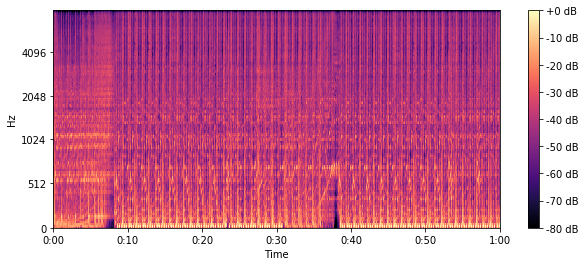

In [18]:
# club
rand_club_track = np.random.choice(meta_data_df.loc[meta_data_df['genre_target'] == 'club','guid'],
                                   1)
print(rand_club_track[0])
plot_spect(rand_club_track[0])


##### Bass


c73dbd92-a8d2-448b-a03b-58a77e214dcf
(2584, 128)


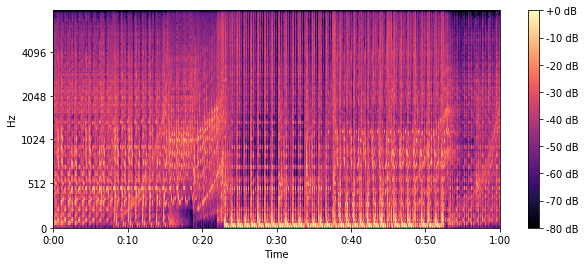

In [19]:
# bass
rand_bass_track = np.random.choice(meta_data_df.loc[meta_data_df['genre_target'] == 'bass-other','guid'],
                                   1)
print(rand_bass_track[0])
plot_spect(rand_bass_track[0])
    

#### Prepare Train/Test Data for Modelling Phase


In [84]:
def create_features_label_array(df):
    genres = []
    X_spect = np.empty((0, 640, 128))
    count = 0
    #Code skips records in case of errors
    for index, row in df.iterrows():
        try:
            count += 1
            track_id = row['guid']
            genre = str(row[('guid', 'genre_target')])
            spect = create_spectogram(track_id)

            # Normalize for small shape differences
            spect = spect[:640, :]
            X_spect = np.append(X_spect, [spect], axis=0)
            genres.append(genre_target_dict[genre])
            if count % 100 == 0:
                print("Currently processing: ", count)
        except:
            print("Couldn't process: ", count)
            continue
    y = np.array(genres)
    return X_spect, y


#### Train, validation, test sets


In [85]:
df_train = meta_data_df[meta_data_df['split'] == 'train']
df_valid = meta_data_df[meta_data_df['split'] == 'valid']
df_test  = meta_data_df[meta_data_df['split'] == 'test']

print(df_train.shape, df_valid.shape, df_test.shape)


(2024, 4) (579, 4) (289, 4)


In [91]:
X_test, y_test = create_features_label_array(df_test)























Couldn't process:  1
Couldn't process:  2
Couldn't process:  3
Couldn't process:  4
Couldn't process:  5
Couldn't process:  6
Couldn't process:  7
Couldn't process:  8
Couldn't process:  9
Couldn't process:  10
Couldn't process:  11
Couldn't process:  12
Couldn't process:  13
Couldn't process:  14
Couldn't process:  15
Couldn't process:  16
Couldn't process:  17
Couldn't process:  18
Couldn't process:  19
Couldn't process:  20
Couldn't process:  21
Couldn't process:  22
Couldn't process:  23
Couldn't process:  24
Couldn't process:  25
Couldn't process:  26
Couldn't process:  27
Couldn't process:  28
Couldn't process:  29
Couldn't process:  30
Couldn't process:  31
Couldn't process:  32
Couldn't process:  33
Couldn't process:  34
Couldn't process:  35
Couldn't process:  36
Couldn't process:  37
Couldn't process:  38
Couldn't process:  39
Couldn't process:  40
Couldn't process:  41
Couldn't process:  42
Couldn't process:  43
Couldn't process:  44
Couldn't process:  45
Couldn't process:  

In [22]:
df_test_test = df_test.iloc[:1,:]


In [80]:
genres = []
X_spect = np.empty((0, 640, 128))
count = 0
for index, row in df_test_test.iterrows():
    try:
        count += 1
        id = row['guid']
        genre = row['genre_target']
        spect = create_spectogram(id)

        # Normalize for small shape differences
        spect = spect[:640, :]
        X_spect = np.append(X_spect, [spect], axis=0)
        genres.append(genre_target_dict[genre])
        if count % 100 == 0:
            print("Currently processing: ", count)
    except:
            print("Couldn't process: ", count)
            continue
y = np.array(genres)


















array([0])

In [71]:
genres = []
X_spect = np.empty((0, 640, 128))
count = 0


In [72]:
id = df_test_test['guid']
print(id.values[0])


75ceb7f7-b249-4690-a2b6-be78980f1f2f


In [73]:
genre = df_test_test['genre_target']
print(genre.values[0])


club


In [74]:
spect = create_spectogram(id.values[0])


In [75]:
# Normalize for small shape differences
spect = spect[:640, :]

In [76]:
X_spect = np.append(X_spect, [spect], axis=0)

In [77]:
genres.append(genre_target_dict[genre.values[0]])

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices